数据/图画要求 
+ a 双个脚压力相同
+ b 左脚压力最大，右脚压力0（过程）
+ c 左脚压力减小，右脚压力增加（过程）
+ d 左脚压力0，右脚压力最大（过程）
+ e 右脚压力减小，左脚压力增大；(过程)
<br>
按照：abcdebcde......这样进行循环；
<br>
过程c和e可以分为3个不同比例体现动态；



1. pressure_data：双脚压力相同
2. interpolated_data:左脚压力最大，右脚压力0

In [38]:
import pandas as pd
import numpy as np
from scipy.interpolate import CubicSpline
from cop_trajectory_analysis.data_loader import PressureDataLoader, CoordinateDataLoader
from cop_trajectory_analysis.cop_calculation import (
    left_map_rule,
    right_map_rule,
    calculate_distances,
    calculate_F_COP,
    calculate_cop_xy,
)

def process_pressure_data():
    """
    start_end_data:                存有各个阶段数据的起始和结束数据
    left_right_equal:              两个脚相同压力数据也就是最开始的数据
    left_max_right_zero:           左脚压力最大、右脚压力0(过程)
    left_decrease_right_increase:  左脚压力减小，右脚压力增加（过程）
    left_zero_right_max:           左脚压力0，右脚压力最大（过程）
    right_decrease_left_increase:  右脚压力减小，左脚压力增大（过程）
    
        
    """ 
    df=pd.read_csv('data/start_end_data.csv')
    df=df.drop(index=[0,3,6,9])
    df = df.drop(df.columns[-1], axis=1)
    df = df.reset_index(drop=True)
    data = df.to_numpy()
    data = data.astype(float) 
    # 将每两行转换为一个2x16的矩阵
    n = data.shape[0] // 2
    result = np.array([data[i * 2 : (i + 1) * 2, :] for i in range(n)])
    data=[]
    for i in range(n):
        
        time_points = np.array([0, 1])  # t=0 对应开始数据, t=1 对应左脚支撑数据
        if i + 1 == n:
            # 如果到达最后一个元素，将第二个元素设置为第0个元素
            positions = np.array([result[i], result[0]])
        else:
            positions = np.array([result[i], result[i + 1]])
        # 创建样条插值模型
        cs = CubicSpline(time_points, positions)
        # 在0到1之间生成插值点
        t_values = np.linspace(0, 1, 25)
        interpolated_data = cs(t_values)
        data.append(interpolated_data)
    return data

In [39]:
all_period_data=process_pressure_data()
reshaped_data = [element.reshape(-1, 17) for element in all_period_data]

# 初始化 timestamp 计数器
timestamp_counter = 0

for i in range(len(reshaped_data)):
    df = pd.DataFrame(reshaped_data[i], columns=[f"sensor{i}" for i in range(17)])
    df.columns.values[0] = "foot"
    df["timestamp"] = [timestamp_counter+i // 2 for i in range(len(df))]
    timestamp_counter += len(df) // 2
    df.to_csv(f"data/{i}.csv", index=False)

In [50]:
def create_five_Represent_data():
    """
    前内：1传感器
    前外：10传感器
    中部：5传感器
    后内：15传感器
    后外：7传感器

    因为每一个帧都要展示左脚和右脚的这五个数据
    """
    file_paths = ["data/0.csv", "data/1.csv", "data/2.csv", "data/3.csv"]
    dataframes = [pd.read_csv(fs)  for fs in file_paths]

    # 使用concat函数合并所有数据框
    df = pd.concat(dataframes, ignore_index=True)
    # 提取左脚（foot=0）的数据
    left_foot_data = df[df['foot'] == 0][['sensor1', 'sensor10', 'sensor5', 'sensor15', 'sensor7']]

    # 提取右脚（foot=1）的数据
    right_foot_data = df[df["foot"] == 1][
        ["sensor1", "sensor10", "sensor5", "sensor15", "sensor7"]
    ]
    # 转换为字典
    left_foot_dict = left_foot_data.to_dict(orient='list')
    right_foot_dict = right_foot_data.to_dict(orient='list')
    # 输出结果
    return left_foot_dict,right_foot_dict

In [41]:
left_foot_dict, right_foot_dict=create_five_Represent_data()
left_foot_dict

{'sensor1': [58.23,
  61.11416666666666,
  63.99833333333333,
  66.8825,
  69.76666666666667,
  72.65083333333332,
  75.535,
  78.41916666666665,
  81.30333333333333,
  84.1875,
  87.07166666666666,
  89.95583333333333,
  92.84,
  95.72416666666666,
  98.60833333333332,
  101.4925,
  104.37666666666668,
  107.26083333333332,
  110.145,
  113.02916666666668,
  115.91333333333333,
  118.7975,
  121.68166666666666,
  124.56583333333332,
  127.45,
  127.45,
  124.69083333333332,
  121.93166666666669,
  119.1725,
  116.41333333333334,
  113.65416666666668,
  110.895,
  108.13583333333334,
  105.37666666666668,
  102.6175,
  99.85833333333332,
  97.09916666666668,
  94.34,
  91.58083333333336,
  88.82166666666667,
  86.0625,
  83.30333333333334,
  80.54416666666668,
  77.785,
  75.02583333333334,
  72.26666666666668,
  69.50750000000001,
  66.74833333333333,
  63.98916666666668,
  61.23,
  61.23,
  58.71125,
  56.1925,
  53.67375,
  51.155,
  48.63625,
  46.1175,
  43.59875,
  41.08,
  38.56

In [42]:
from scipy.interpolate import CubicSpline

# 定义数据点（时间和对应的重心位置）

def create_rotated_cop_xy():
    """
    0文件-[11,11]--->[6,11]:          从两脚相同到左脚最大，右脚为0
    1文件-[6,11]--->[11,11]:          从左脚压力最大到右脚为0 到 左脚压力减小，右脚压力增加
    2文件-[11,11]-->[16,11]:          从左脚压力减小，右脚压力增大 到 左脚压力为0，右脚压力最大
    3文件-[16,11]-->[11,11]:          从左脚压力减小，右脚压力增加 到 右脚压力减小，左脚压力增大
    4文件-[11,11]-->[11,11]:          从右脚压力减小，左脚压力增大 到 右脚压力最大，左脚压力为0
    """

    time_points = np.array([0,1,2,3,4])  # t=0 对应开始数据, t=1 对应左脚支撑数据
    positions = np.array([[11,11],[6,11],[11,11],[16,11],[11,11]])  # 对应的重心位置

    # 创建样条插值模型
    cs = CubicSpline(time_points, positions)

    # 在0到1之间生成插值点
    t_values = np.linspace(0, 4, 100)
    interpolated_data = cs(t_values)
    return interpolated_data

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from scipy.ndimage import gaussian_filter
import cv2
import matplotlib.image as mpimg


def create_heatmap(
    index, total_sensor_xy, total_pressure, rotated_cop_xy_list, out_video
):
    # 自定义颜色映射
    colors = [
        (1.0, 1.0, 1.0, 0.0),  # 白色
        (0.0, 1.0, 1.0, 1.0),  # 青色
        (0.0, 0.0, 1.0, 1.0),  # 蓝色
        (0.0, 1.0, 0.0, 1.0),  # 绿色
        (1.0, 1.0, 0.0, 1.0),  # 黄色
        (1.0, 0.0, 0.0, 1.0),  # 红色
    ]
    cmap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=256)
    figure_data = np.zeros(shape=(22, 22))
    for (x, y), pressure in zip(total_sensor_xy, total_pressure):
        figure_data[x, y] = pressure

    smoothed_data = gaussian_filter(figure_data, sigma=0.7)
    max_smoothed = np.max(smoothed_data)
    norma_smoothed = smoothed_data / max_smoothed
    rotated_norma_smoothed = np.rot90(norma_smoothed)

    # 创建平滑热力图
    fig, ax_heatmap = plt.subplots(figsize=(10, 10))

    heatmap=ax_heatmap.imshow(
        rotated_norma_smoothed,
        cmap=cmap,
        interpolation="bilinear",
        vmin=0,
        vmax=0.99,
        zorder=6,
        alpha=0.5,
    )
    # 读取图片
    left = mpimg.imread("assets/left-1.png")
    right = mpimg.imread("assets/right-1.png")
    # 显示图片并指定显示区域
    ax_heatmap.imshow(
        left, extent=[2, 7, 15, 6], zorder=5
    )  # 图片显示在 (2, 8) 和 (3, 7) 的区域
    ax_heatmap.imshow(
        right, extent=[15, 20, 15, 6], zorder=5
    )  # 图片2显示在 (6, 9) 和 (2, 5) 的区域

    # 假设你有一个列表来存储之前帧的点
    previous_points = []
    # 清除之前帧的五个点
    for point in previous_points:
        point.remove()
    # 清空列表
    previous_points.clear()
    tail_length = 20
    for i, point in enumerate(rotated_cop_xy_list):
        if index-15< i < index:
            # 当前点之后的点，形成拖尾效果
            distance = index - i
            # 透明度随着距离增加而增加
            alpha = 1-(distance / tail_length)
            color_intensity = 1 - alpha

            scatter = plt.scatter(
                *point,
                edgecolor=(color_intensity, 0, alpha),
                facecolor="none",
                s=5,
                zorder=5,
                alpha=alpha
            )  # 其他点为空心
            # 清空列表
            previous_points.append(scatter)  # 将点添加到列表中
        elif i == index:
            plt.scatter(*point, color="red", s=250, zorder=5)  # 突出显示当前点
        # elif index < i <=index +5:
        #     plt.scatter(
        #         *point, edgecolor="black", facecolor="none", s=5, zorder=5, alpha=0.2
        #     )  # 其他点为空心
    # 创建图形和网格布局

    # 示例数据
    categories = ["A", "B", "C", "D","E"]
    left_foot_dict, right_foot_dict = create_five_Represent_data()
    left_first_values = [ value[index] for key, value in left_foot_dict.items()]
    right_first_values = [ value[index] for key, value in right_foot_dict.items()]

    left_values = left_first_values
    right_values = right_first_values
    # 创建颜色映射
    norm = plt.Normalize(
        vmin=min(left_values + right_values),
        vmax=max(left_values + right_values),
    )

    bar_colors = [
        (0.0, 1.0, 1.0, 1.0),  # 青色
        (0.0, 0.0, 1.0, 1.0),  # 蓝色
        (0.0, 1.0, 0.0, 1.0),  # 绿色
        (1.0, 1.0, 0.0, 1.0),  # 黄色
        (1.0, 0.0, 0.0, 1.0),  # 红色
    ]
    bar_cmap = LinearSegmentedColormap.from_list("custom_cmap", bar_colors, N=256)

    colors_left = bar_cmap(norm(left_values))
    colors_right = bar_cmap(norm(right_values))
    # 创建左侧柱状图的子图
    ax_left_bar = ax_heatmap.inset_axes([0.1, 0.8, 0.35, 0.15], facecolor="none")  # 左侧
    y_pos = np.arange(len(categories))
    ax_left_bar.barh(
        y_pos,
        left_values,
        color=colors_left,
        alpha=0.7,
        height=0.6,
        label="Left Chart",
    )
    ax_left_bar.set_xscale("log")
    ax_left_bar.set_yticks(y_pos)
    ax_left_bar.set_yticklabels(categories)

    # 创建右侧柱状图的子图
    ax_right_bar = ax_heatmap.inset_axes([0.55, 0.8, 0.35, 0.15], facecolor="none")  # 右侧
    ax_right_bar.barh(
        y_pos,
        right_values,
        color=colors_right,
        alpha=0.7,
        height=0.6,
        label="Right Chart",
    )
    ax_right_bar.set_xscale("log")
    ax_right_bar.set_yticks(y_pos)
    ax_right_bar.set_yticklabels(categories)
    ax_right_bar.invert_xaxis()  # 翻转x轴
    ax_right_bar.yaxis.tick_right()  # 标签放到右侧

    # 在左侧柱状图上添加数据标签
    for i, value in enumerate(left_values):
        ax_left_bar.text(
            max(left_values) + 0.05, i, f"{value:.2f}", va="center", ha="left", color="black"
        )
    # 在右侧柱状图上添加数据标签
    for i, value in enumerate(right_values):
        ax_right_bar.text(
            max(right_values) + 0.05,
            i,
            f"{value:.2f}",
            va="center",
            ha="right",
            color="black",
        )

    # 去掉柱状图的框线和轴
    for ax in [ax_left_bar, ax_right_bar]:
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
        ax.xaxis.set_visible(False)
    # plt.plot(
    #     rotated_cop_xy_list[:, 0],
    #     rotated_cop_xy_list[:, 1],
    #     color="grey",
    #     linestyle="--",
    # )  # 连接轨迹

    # plt.scatter(rotated_cop_xy_list[index][0],rotated_cop_xy_list[index][1], color="black", s=100, zorder=5)

    ax_heatmap.scatter(x, y, color="black", s=10, alpha=0.5, zorder=5)
    ax_heatmap.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

    plt.tight_layout()
    # 保存当前帧
    plt.savefig("temp_frame.png")
    plt.close()

    # 读取帧并写入视频
    img = cv2.imread("temp_frame.png")
    out_video.write(img)    

In [44]:
def create_image_data(index,pressure_loader,coordinate_loader):
    pressure_data = pressure_loader.load_pressure()[index]
    coordinate_data = coordinate_loader.load_coordinates()["2025-02-11T15:50:51"]
    total_sensor_xy = coordinate_loader.get_total_coordinate()["2025-02-11T15:50:51"]
    total_pressure = pressure_loader.get_total_pressure()[index]
    return total_sensor_xy, total_pressure

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from scipy.ndimage import gaussian_filter
import cv2
cycle=3
file_paths=['data/0.csv','data/1.csv','data/2.csv','data/3.csv']    
pressure_loader = PressureDataLoader(file_path=file_paths)
coordinate_loader = CoordinateDataLoader(
        file_path="data/coordinate_data.csv",
        left_map=left_map_rule,
        right_map=right_map_rule,
    )
# dataframes = [pd.read_csv(fs)  for _ in range(cycle)   for fs in file_paths]
# df = pd.concat(dataframes, ignore_index=True)
rotated_cop_xy_list = create_rotated_cop_xy()

# rotated_cop_xy_list
# 视频设置
size = (1000, 1000)  # 根据实际图片大小设置11
out = cv2.VideoWriter("output_video.avi", cv2.VideoWriter_fourcc(*"XVID"), 10, size)
for _ in range(cycle):
    for t in range(100):
        totoal_sensor_xy, total_pressure = create_image_data(
            t, pressure_loader=pressure_loader,coordinate_loader=coordinate_loader)
        create_heatmap(
            index=t,
            total_sensor_xy=totoal_sensor_xy,
            total_pressure=total_pressure,
            rotated_cop_xy_list=rotated_cop_xy_list,
            out_video=out,
        )
out.release()

In [46]:
left_foot_dict, right_foot_dict = create_five_Represent_data()
len(left_foot_dict["sensor1"])

125

0.0010586480748404803
[11 11]


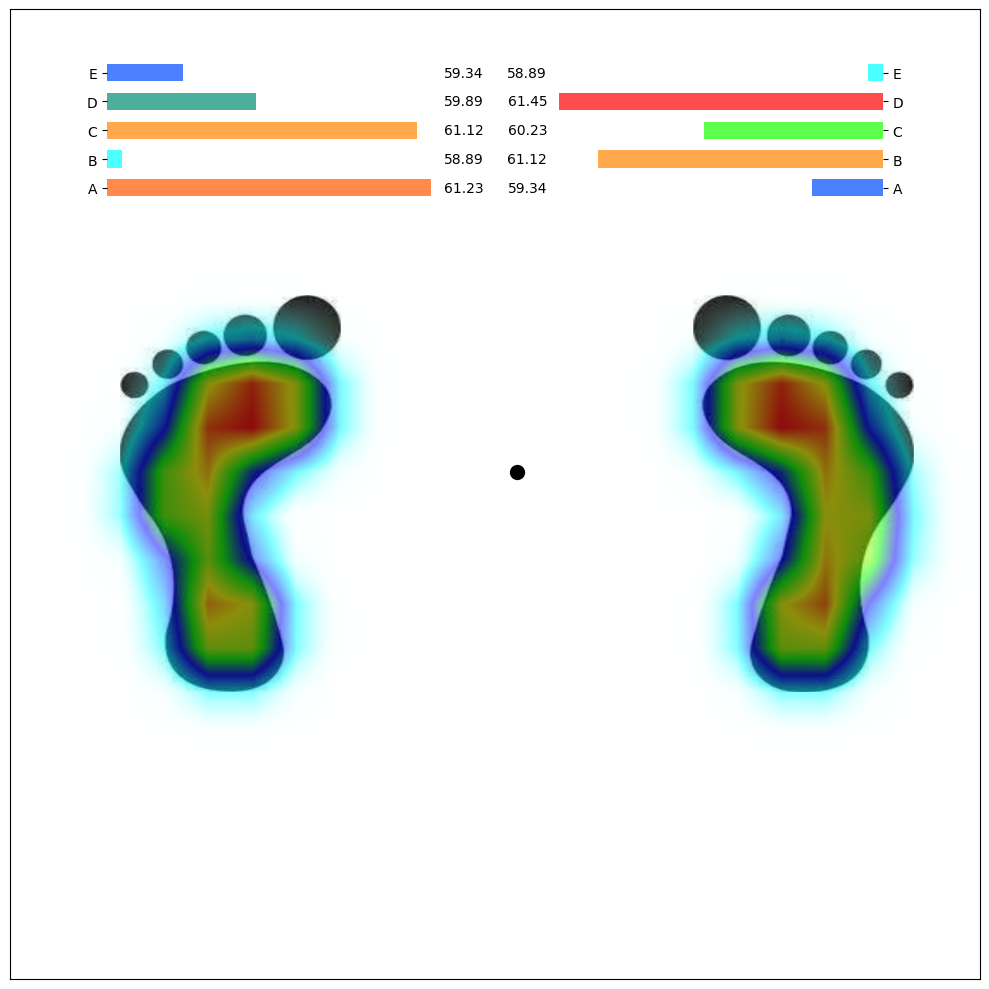

[11 11 10 10]


In [62]:
from cop_trajectory_analysis.data_loader import PressureDataLoader, CoordinateDataLoader
from cop_trajectory_analysis.cop_calculation import (
    left_map_rule,
    right_map_rule,
    calculate_distances,
    calculate_F_COP,
    calculate_cop_xy,
)
import numpy as np
from itertools import chain
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from scipy.ndimage import gaussian_filter
import random
import matplotlib.image as mpimg
import matplotlib.cm as cm
import pandas as pd
pressure_loader = PressureDataLoader(file_path="data/pressure_data.csv")
pressure_data = pressure_loader.load_pressure()["2025-02-11T15:50:46"]
coordinate_loader = CoordinateDataLoader(
    file_path="data/coordinate_data.csv",
    left_map=left_map_rule,
    right_map=right_map_rule,
)
coordinate_data = coordinate_loader.load_coordinates()["2025-02-11T15:50:46"]
total_sensor_xy = coordinate_loader.get_total_coordinate()["2025-02-11T15:50:46"]
total_pressure = pressure_loader.get_total_pressure()["2025-02-11T15:50:46"]


# 计算压力中心坐标
cop_xy = calculate_cop_xy(pressures=total_pressure, coordinates=total_sensor_xy)
# 计算每个传感器到压力中心的距离
sensor_distance = calculate_distances(
    sensor_coords=total_sensor_xy, center_coords=cop_xy
)
# 计算压力中心的数值
F_COP = calculate_F_COP(pressures=total_pressure, distances=sensor_distance)

"""
以下是绘制热力图的代码
"""
cop_xy_int = np.array(cop_xy).astype(int)


max_pressure = np.max(total_pressure)
normalized_pressure = (total_pressure / max_pressure) + 2


# 自定义颜色映射
colors = [
    (1.0, 1.0, 1.0, 0.0),  # 白色
    (0.0, 1.0, 1.0, 1.0),  # 青色
    (0.0, 0.0, 1.0, 1.0),  # 蓝色
    (0.0, 1.0, 0.0, 1.0),  # 绿色
    (1.0, 1.0, 0.0, 1.0),  # 黄色
    (1.0, 0.0, 0.0, 1.0),  # 红色
]
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=256)

figure_data = np.zeros(shape=(22, 22))
for (x, y), pressure in zip(total_sensor_xy, total_pressure):
    figure_data[x, y] = pressure

figure_data[cop_xy_int[0], cop_xy_int[1]] = np.floor(F_COP) / max_pressure

smoothed_data = gaussian_filter(figure_data, sigma=0.7)


max_smoothed = np.max(smoothed_data)
norma_smoothed = smoothed_data / max_smoothed

rotated_norma_smoothed = np.rot90(norma_smoothed)

n = norma_smoothed.shape[0]
cop_xy_int[1] = cop_xy_int[1] + 1

rotated_cop_xy = (cop_xy_int[1], n - 1 - cop_xy_int[0])
# rotated_cop_xy=np.rot90(cop_xy_int)
print(norma_smoothed[cop_xy_int[0], cop_xy_int[1]])


fig, ax_heatmap = plt.subplots(figsize=(10, 10))
# 创建图形和网格布局


# 示例数据
categories = ["A", "B", "C", "D","E"]
left_foot_dict, right_foot_dict = create_five_Represent_data()
left_first_values = [ value[50] for key, value in left_foot_dict.items()]
right_first_values = [ value[50] for key, value in right_foot_dict.items()]

left_values = left_first_values
right_values = right_first_values


# 创建颜色映射
norm = plt.Normalize(
    vmin=min(left_values + right_values),
    vmax=max(left_values + right_values),
)

bar_colors = [
    (0.0, 1.0, 1.0, 1.0),  # 青色
    (0.0, 0.0, 1.0, 1.0),  # 蓝色
    (0.0, 1.0, 0.0, 1.0),  # 绿色
    (1.0, 1.0, 0.0, 1.0),  # 黄色
    (1.0, 0.0, 0.0, 1.0),  # 红色
]
bar_cmap = LinearSegmentedColormap.from_list("custom_cmap", bar_colors, N=256)

colors_left = bar_cmap(norm(left_values))
colors_right = bar_cmap(norm(right_values))

# 创建左侧柱状图的子图
ax_left_bar = ax_heatmap.inset_axes([0.1, 0.8, 0.35, 0.15], facecolor="none")  # 左侧
y_pos = np.arange(len(categories))
ax_left_bar.barh(
    y_pos,
    left_values,
    color=colors_left,
    alpha=0.7,
    height=0.6,
    label="Left Chart",
)
ax_left_bar.set_xscale("log")
ax_left_bar.set_yticks(y_pos)
ax_left_bar.set_yticklabels(categories)


# 创建右侧柱状图的子图
ax_right_bar = ax_heatmap.inset_axes([0.55, 0.8, 0.35, 0.15], facecolor="none")  # 右侧
ax_right_bar.barh(
    y_pos,
    right_values,
    color=colors_right,
    alpha=0.7,
    height=0.6,
    label="Right Chart",
)
ax_right_bar.set_xscale("log")
ax_right_bar.set_yticks(y_pos)
ax_right_bar.set_yticklabels(categories)
ax_right_bar.invert_xaxis()  # 翻转x轴
ax_right_bar.yaxis.tick_right()  # 标签放到右侧

# 在左侧柱状图上添加数据标签
for i, value in enumerate(left_values):
    ax_left_bar.text(
        max(left_values)+0.1, i, f"{value:.2f}", va="center", ha="left", color="black"
    )
# 在右侧柱状图上添加数据标签
for i, value in enumerate(right_values):
    ax_right_bar.text(
        max(right_values)+0.1, i, f"{value:.2f}", va="center", ha="right", color="black"
    )

# 去掉柱状图的框线和轴
for ax in [ax_left_bar, ax_right_bar]:
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.xaxis.set_visible(False)

# 创建平滑热力图
heatmap = ax_heatmap.imshow(
    rotated_norma_smoothed,
    cmap=cmap,
    interpolation="bilinear",
    vmin=0,
    vmax=0.99,
    zorder=6,
    alpha=0.5,
)

# 读取图片
left = mpimg.imread("assets/left-1.png")
right = mpimg.imread("assets/right-1.png")


# 显示图片并指定显示区域
ax_heatmap.imshow(left, extent=[2, 7, 15, 6], zorder=5)  # 图片显示在 (2, 8) 和 (3, 7) 的区域
ax_heatmap.imshow(
    right, extent=[15, 20, 15, 6], zorder=5
)  # 图片2显示在 (6, 9) 和 (2, 5) 的区域


ax_heatmap.scatter(rotated_cop_xy[0], rotated_cop_xy[1], color="black", s=100, zorder=5)
print(cop_xy_int)
# 创建点状背景
ax_heatmap.scatter(x, y, color="black", s=10, alpha=0.5, zorder=5)

# 隐藏刻度线和刻度标签
ax_heatmap.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
# 调整布局
plt.tight_layout()
plt.show()

print(left_values_smoothed)

轨迹不能重合，到左边的时候，要到左边脚的中心。到右边的时候，到右边脚的中心

/var/folders/cb/8_fz48_s1c14r0z10lvg3hb00000gn/T/ipykernel_17729/1559559306.py:99: UserWarning: Glyph 36724 (\N{CJK UNIFIED IDEOGRAPH-8F74}) missing from current font.
  plt.tight_layout()
/var/folders/cb/8_fz48_s1c14r0z10lvg3hb00000gn/T/ipykernel_17729/1559559306.py:99: UserWarning: Glyph 24179 (\N{CJK UNIFIED IDEOGRAPH-5E73}) missing from current font.
  plt.tight_layout()
/var/folders/cb/8_fz48_s1c14r0z10lvg3hb00000gn/T/ipykernel_17729/1559559306.py:99: UserWarning: Glyph 28369 (\N{CJK UNIFIED IDEOGRAPH-6ED1}) missing from current font.
  plt.tight_layout()
/var/folders/cb/8_fz48_s1c14r0z10lvg3hb00000gn/T/ipykernel_17729/1559559306.py:99: UserWarning: Glyph 28909 (\N{CJK UNIFIED IDEOGRAPH-70ED}) missing from current font.
  plt.tight_layout()
/var/folders/cb/8_fz48_s1c14r0z10lvg3hb00000gn/T/ipykernel_17729/1559559306.py:99: UserWarning: Glyph 21147 (\N{CJK UNIFIED IDEOGRAPH-529B}) missing from current font.
  plt.tight_layout()
/var/folders/cb/8_fz48_s1c14r0z10lvg3hb00000gn/T/ipyker

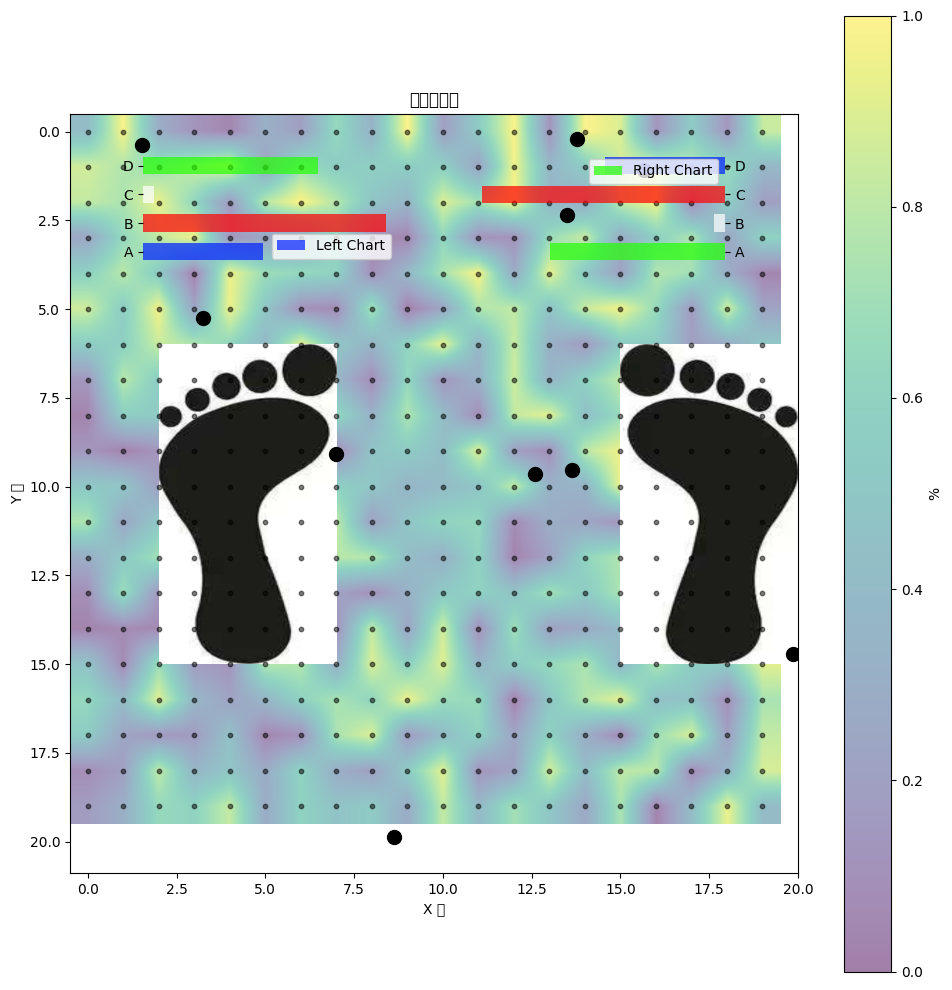

In [48]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from scipy.ndimage import gaussian_filter

# 自定义颜色映射
colors = [
    (1.0, 1.0, 1.0, 0.0),  # 白色
    (0.0, 1.0, 1.0, 1.0),  # 青色
    (0.0, 0.0, 1.0, 1.0),  # 蓝色
    (0.0, 1.0, 0.0, 1.0),  # 绿色
    (1.0, 1.0, 0.0, 1.0),  # 黄色
    (1.0, 0.0, 0.0, 1.0),  # 红色
]
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=256)

# 示例数据
categories = ["A", "B", "C", "D"]
left_values = [10, 15, 7, 12]
right_values = [12, 7, 15, 10]

# 对数据进行高斯模糊处理
left_values_smoothed = gaussian_filter(left_values, sigma=1)
right_values_smoothed = gaussian_filter(right_values, sigma=1)

# 创建图形
fig, ax_heatmap = plt.subplots(figsize=(10, 10))

# 创建平滑热力图
heatmap = ax_heatmap.imshow(
    np.random.rand(20, 20),  # 示例数据
    cmap="viridis",
    interpolation="bilinear",
    vmin=0,
    vmax=1,
    zorder=1,
    alpha=0.5,
)

# 读取并显示图片
left = mpimg.imread("assets/left-1.png")
right = mpimg.imread("assets/right-1.png")
ax_heatmap.imshow(left, extent=[2, 7, 15, 6], zorder=2)
ax_heatmap.imshow(right, extent=[15, 20, 15, 6], zorder=2)

# 添加点状背景和其他元素
ax_heatmap.scatter(
    np.random.rand(10) * 20, np.random.rand(10) * 20, color="black", s=100, zorder=3
)
x, y = np.meshgrid(np.arange(20), np.arange(20))
ax_heatmap.scatter(x, y, color="black", s=10, alpha=0.5, zorder=3)

# 添加热力图的标签和标题
ax_heatmap.set_title("平滑热力图")
ax_heatmap.set_xlabel("X 轴")
ax_heatmap.set_ylabel("Y 轴")
fig.colorbar(heatmap, ax=ax_heatmap, label="%")

# 创建颜色映射
norm = plt.Normalize(
    vmin=min(left_values + right_values), vmax=max(left_values + right_values)
)

# 创建左侧柱状图的子图
ax_left_bar = ax_heatmap.inset_axes([0.1, 0.8, 0.35, 0.15], facecolor="none")  # 左侧
y_pos = np.arange(len(categories))
colors_left = cmap(norm(left_values))
ax_left_bar.barh(
    y_pos, left_values, color=colors_left, alpha=0.7, height=0.6, label="Left Chart"
)
ax_left_bar.set_xscale("log")
ax_left_bar.set_yticks(y_pos)
ax_left_bar.set_yticklabels(categories)
ax_left_bar.legend()

# 创建右侧柱状图的子图
ax_right_bar = ax_heatmap.inset_axes([0.55, 0.8, 0.35, 0.15], facecolor="none")  # 右侧
colors_right = cmap(norm(right_values))
ax_right_bar.barh(
    y_pos, right_values, color=colors_right, alpha=0.7, height=0.6, label="Right Chart"
)
ax_right_bar.set_xscale("log")
ax_right_bar.invert_xaxis()  # 翻转x轴
ax_right_bar.set_yticks(y_pos)
ax_right_bar.set_yticklabels(categories)
ax_right_bar.yaxis.tick_right()  # 标签放到右侧
ax_right_bar.legend()

# 去掉柱状图的框线和轴
for ax in [ax_left_bar, ax_right_bar]:
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.xaxis.set_visible(False)

# 调整布局
plt.tight_layout()
plt.show()